In [9]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.dummy import DummyClassifier
from numpy import mean,std
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import shap  
from sklearn.metrics import classification_report


In [10]:
df = pd.read_csv('..\data\diabetes_data_upload.csv')

# EDA

In [122]:
df.describe()

,Age,class
count,520.000000,520.000000
mean,48.028846,0.615385
std,12.151466,0.486973
min,16.000000,0.000000
25%,39.000000,0.000000
50%,47.500000,1.000000
75%,57.000000,1.000000
max,90.000000,1.000000


In [11]:
# identificando o tipo de variáveis do dataset e a proporção de colunas e linhas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [95]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas')

O dataset possui 520 linhas e 17 colunas


A maioria das variáveis está identificada com objeto. Apenas a variável "Age" é um valor inteiro.

In [96]:
df.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

Não há valores nulos no dataset

In [100]:
df.Age.unique()

array([40, 58, 41, 45, 60, 55, 57, 66, 67, 70, 44, 38, 35, 61, 54, 43, 62,
       39, 48, 32, 42, 52, 53, 37, 49, 63, 30, 50, 46, 36, 51, 59, 65, 25,
       47, 28, 68, 56, 31, 85, 90, 72, 69, 79, 34, 16, 33, 64, 27, 29, 26],
      dtype=int64)

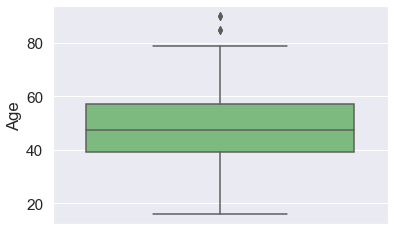

In [102]:
sns.boxplot(y="Age", hue="class", data=df, palette="Greens");


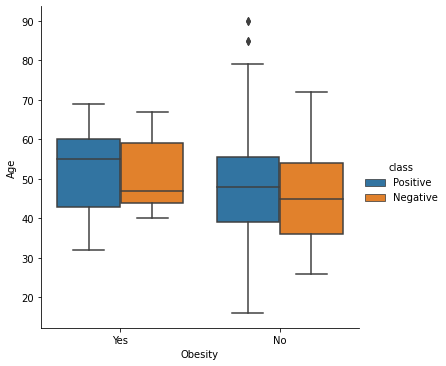

In [15]:
sns.catplot(x="Obesity", y="Age", hue="class", kind="box", data=df);


## Contabilizando a proporção das classes do target "class"

In [16]:
df['class'].value_counts()

Positive    320
Negative    200
Name: class, dtype: int64

Class Positive: 0.6153846153846154
Class Negative: 0.38461538461538464
Proporção: 1.6 : 1


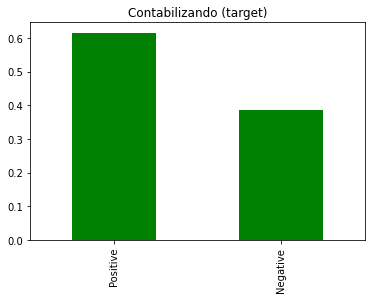

In [17]:
target = df['class'].value_counts(normalize=True)
print('Class Positive:', target[0])
print('Class Negative:', target[1])
print('Proporção:', round(target[0] / target[1], 2), ': 1')

target.plot(kind='bar', color='green', title='Contabilizando (target)');

Observamos uma maior quantidade de valores positivos maior que negativo nos diagnósticos de diabetes para o dataset. A proporção de 1.6:1 evidencia um relativo desbalanceamento nos dados.
    Dessa forma, devemos observar como tratar essa informação ao construir um modelo que seja capaz de realizar essa classificação sem que o mesmo fique enviesado pela classe maioritaria (diagnósticos positivos)

In [18]:
# Verificando as proporções das classes das demais colunas

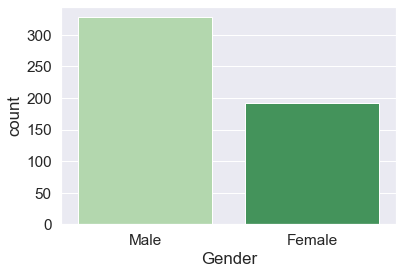

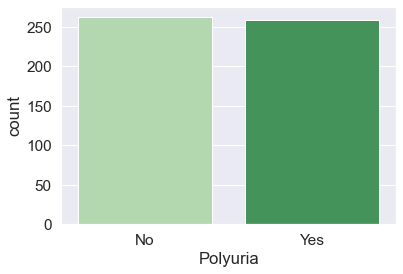

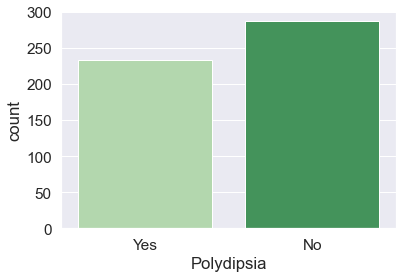

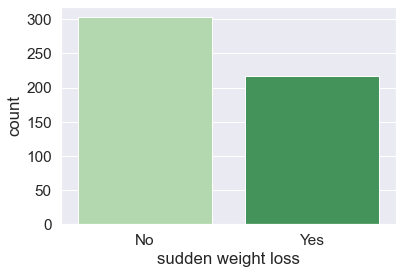

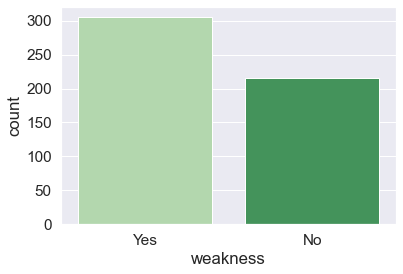

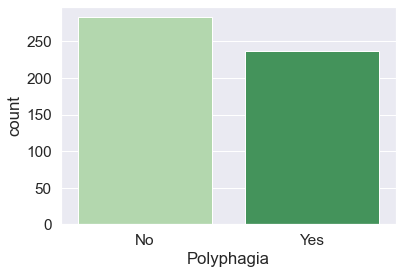

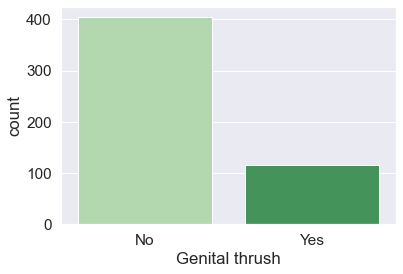

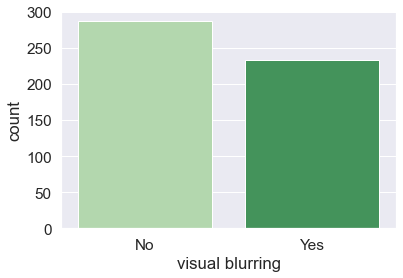

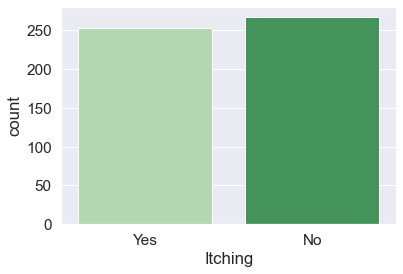

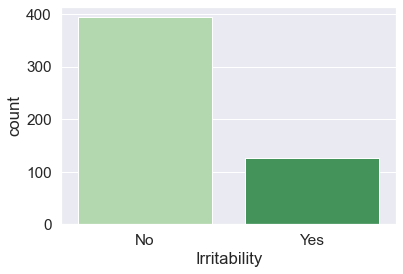

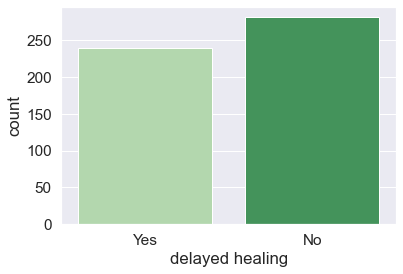

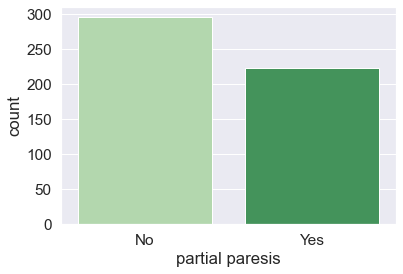

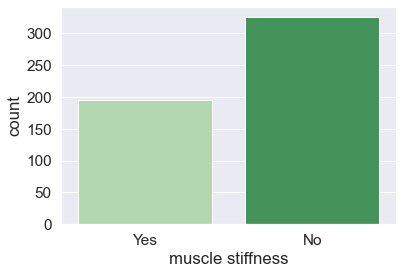

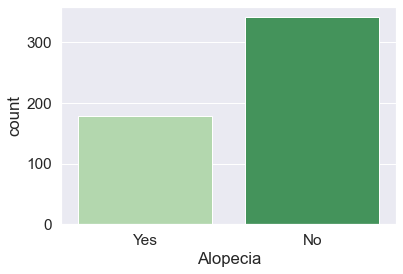

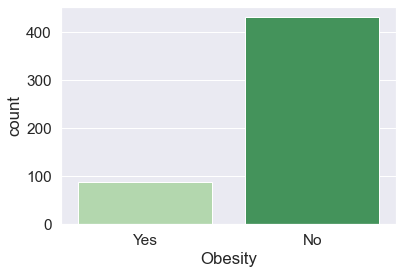

In [104]:
for i,col in enumerate(df.columns[1:-1]):
    plt.figure(i)
    sns.countplot(x=df[col],data=df,palette="Greens")


Algumas constatações podem ser identificadas ao analisar os gráficos. Constatamos que a maioria das pessoas nos exemplos observados não são obesas. Além disso, temos uma maior proporção de homens. Iremos aprofundar nossas análises a partir dessas informações.

<AxesSubplot:xlabel='Gender', ylabel='count'>

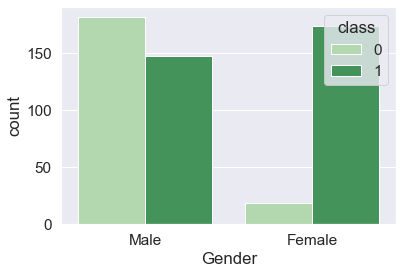

In [103]:
# identificando a relação do gênero com o diagnóstico de diabetes
sns.countplot(x=df['Gender'],hue=df['class'],palette="Greens")


Embora o número de homens no dataset seja maior, a proporção de mulheres com diagnóstico positivo é superior ao dos homens.

<AxesSubplot:xlabel='Obesity', ylabel='count'>

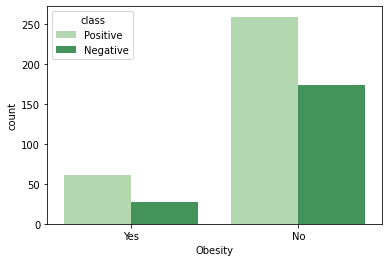

In [22]:
sns.countplot(x=df['Obesity'],hue=df['class'],palette="Greens")

Observa-se uma maior proporção de pessoas não obesas com diagnóstico postivo para diabetes, embora, saíbamos que a proporção de pessoas não obesas no geral é maior.

# Identificando variáveis com maiores proporções de casos positivos

Iremos analisar o dataset tomando como referência os casos positivos para identificar as variáveis que tem maior proporção de ter diagnósticos positivos

In [105]:
def columns_to_dummies(df):
    '''
    Essa função altera os labels das colunas de string para valores binários.
    '''
    df['class']=df['class'].replace(['Positive'],1)
    df['class']=df['class'].replace(['Negative'],0)
    df=df.replace(['Yes'], 1)
    df=df.replace(['No'],0)
    df = pd.get_dummies(df, columns = ['Gender'])
    return df

In [106]:
df2 = columns_to_dummies(df)

In [107]:
df2

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Gender_Female,Gender_Male
0,40,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,1
1,58,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1
2,41,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1
3,45,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0
516,48,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,0
517,58,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,0
518,32,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0


In [108]:
# calculando a proporção de casos positivos e relacionando com os inputs
class_positive=df2.loc[df2['class'] == 1]
positives_total=df2.sum()
positives_per_feat=class_positive.sum()/positives_total

In [109]:
positives_per_feat.pop('class');

In [110]:
positives_per_feat.sort_values(ascending=False)

Polydipsia            0.965665
Polyuria              0.941860
Gender_Female         0.901042
Irritability          0.873016
sudden weight loss    0.866359
partial paresis       0.857143
Polyphagia            0.797468
visual blurring       0.751073
Genital thrush        0.715517
weakness              0.714754
Obesity               0.693182
muscle stiffness      0.692308
delayed healing       0.640167
Age                   0.628749
Itching               0.608696
Gender_Male           0.448171
Alopecia              0.435754
dtype: float64

In [111]:
percentages = pd.DataFrame(positives_per_feat.sort_values(ascending=False))

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


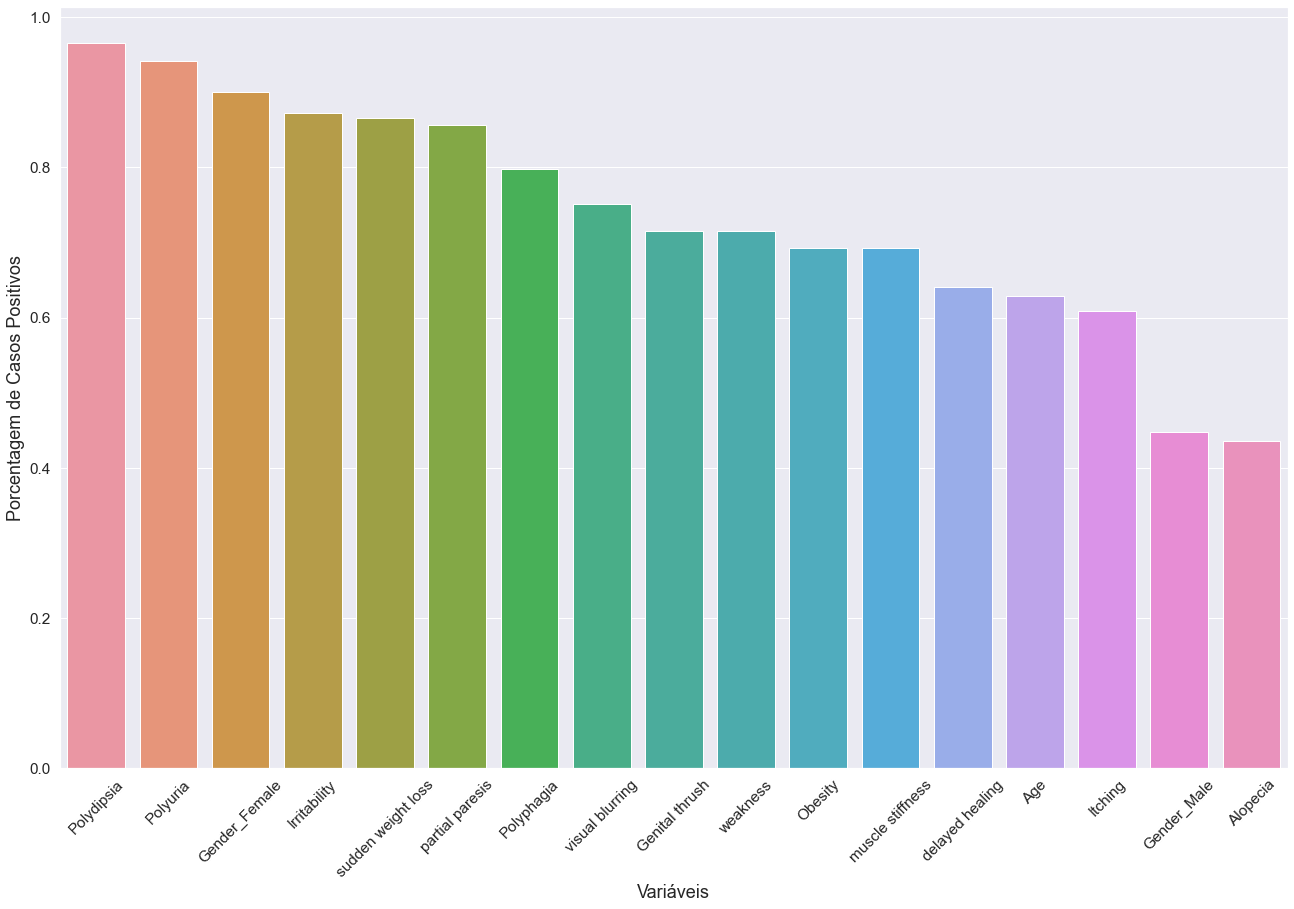

In [112]:
plt.figure(figsize=(22,14))

sns.set(font_scale=1.4)
sns.barplot(percentages.index,percentages[0])
plt.xticks(rotation=45)
plt.xlabel('Variáveis',fontsize=18)
plt.ylabel('Porcentagem de Casos Positivos',fontsize=18);
plt.savefig('../figures/most_important_features.png',dpi=100,bbox_inches='tight')

Podemos constatar pela proporção de casos positivos para cada uma das variáveis que a Polydipsia, Polyuria e o Gênero  são as variáveis que mais contribuem para diagnósticos positivos. Os casos de alopecia são os que estão menos relacionados ao diganóstico positivo de diabetes. Resultado similar pode ser identificado na correlação dessas variáveis

In [113]:
correlation = df2.corr()["class"].to_frame()
correlation.sort_values(by='class',ascending=False)[1:]

,class
Polyuria,0.665922
Polydipsia,0.648734
Gender_Female,0.449233
sudden weight loss,0.436568
partial paresis,0.432288
Polyphagia,0.342504
Irritability,0.299467
visual blurring,0.251300
weakness,0.243275
muscle stiffness,0.122474


● Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?

● Qual a relação entre Polyphagia e o diagnóstico de diabetes

In [114]:
age_bin = pd.cut(df2.Age,bins=[0,39,99],labels=['younger_than_40','older_than_40'])
df2.insert(2,'Age_Group',age_bin)


In [115]:
df2.head(12)

,Age,Polyuria,Age_Group,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Gender_Female,Gender_Male
0,40,0,older_than_40,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,1
1,58,0,older_than_40,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1
2,41,1,older_than_40,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1
3,45,0,older_than_40,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,1
4,60,1,older_than_40,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1
5,55,1,older_than_40,1,0,1,1,0,1,1,0,1,0,1,1,1,1,0,1
6,57,1,older_than_40,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1
7,66,1,older_than_40,1,1,1,0,0,1,1,1,0,1,1,0,0,1,0,1
8,67,1,older_than_40,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,1
9,70,0,older_than_40,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1


In [116]:
df2['Age_Group'].value_counts()

older_than_40      376
younger_than_40    144
Name: Age_Group, dtype: int64

In [117]:
df2.groupby(['Gender_Male', 'Age_Group'])['class'].value_counts().rename("count")

Gender_Male  Age_Group        class
0            younger_than_40  1         56
                              0          7
             older_than_40    1        117
                              0         12
1            younger_than_40  0         52
                              1         29
             older_than_40    0        129
                              1        118
Name: count, dtype: int64

In [118]:
df2.groupby(['Gender_Male', 'Age_Group'])['class'].value_counts(normalize=True).rename("count")

Gender_Male  Age_Group        class
0            younger_than_40  1        0.888889
                              0        0.111111
             older_than_40    1        0.906977
                              0        0.093023
1            younger_than_40  0        0.641975
                              1        0.358025
             older_than_40    0        0.522267
                              1        0.477733
Name: count, dtype: float64

Aproximadamente, 35% dos homens com idade inferior a 40 anos possuem chance de ter um diagnóstico positivo para diabetes

In [119]:
# Avaliando os dados de Polyphagia
df2.groupby(['Polyphagia'])['class'].value_counts()

Polyphagia  class
0           0        152
            1        131
1           1        189
            0         48
Name: class, dtype: int64

In [120]:
df2.groupby(['Polyphagia'])['class'].value_counts(normalize=True)

Polyphagia  class
0           0        0.537102
            1        0.462898
1           1        0.797468
            0        0.202532
Name: class, dtype: float64

<AxesSubplot:xlabel='class', ylabel='prop'>

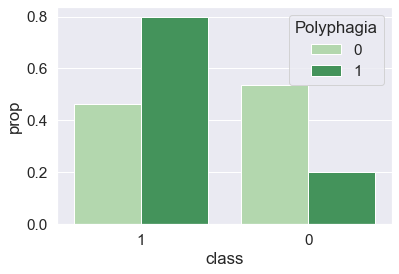

In [121]:
prop_df = (df2['class']
           .groupby(df2['Polyphagia'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='class', y='prop', hue='Polyphagia', data=prop_df,order=df2['class'].value_counts().index,palette="Greens")

Observa-se que, aproximadamente, 80% das pessoas que possuem Polyphagia tem o diagnóstico positivo para diabetes, embora, a sua importância no diagnóstico como visto, anteriomente, não seja tão alta.

# Processamento dos dados

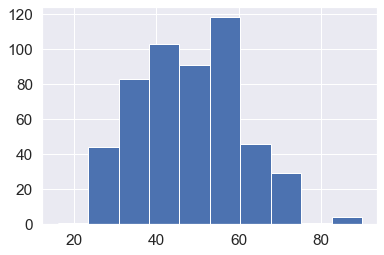

In [40]:
df2['Age'].hist();

In [41]:
df2.groupby(['class'])['Age'].mean()[1]

49.071875

In [42]:
# A maioria dos casos positivos tem em média 49 anos ou mais
df2.groupby(['class'])['Age'].mean()


class
0    46.360000
1    49.071875
Name: Age, dtype: float64

A idade, inicialmente, será considerada no modelo da seguinte forma: pessoas acima de 49 anos e pessoas abaixo de 49 anos. Em média, pessoas com idade igual ou superior a 49 anos podem ter o diagnóstico positivo para diabetes

In [43]:
df2['Age_49'] =  [1 if x >= 49  else 0 for x in df2.Age.values]

In [44]:
df2

,Age,Polyuria,Age_Group,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Gender_Female,Gender_Male,Age_49
0,40,0,older_than_40,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,1,0
1,58,0,older_than_40,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,1
2,41,1,older_than_40,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0
3,45,0,older_than_40,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,1,0
4,60,1,older_than_40,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,younger_than_40,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0
516,48,1,older_than_40,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,0,0
517,58,1,older_than_40,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,0,1
518,32,0,younger_than_40,0,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0


Será proposto um primeiro modelo com todas as variáveis e em seguida este modelo será comparado a um com as 5 principais variáveis identificada no teste do chi quadrado

In [45]:
# Será considerado apenas o Gênero Feminino. Se 1 feminino, se 0 masculino
df3=df2.drop(['Age','Age_Group','Gender_Male'],axis=1)

In [46]:
X = df3.drop('class',axis=1)
y = df3['class']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=True)

In [48]:
# Modelagem

In [49]:
# Create dummy classifer
dummy = DummyClassifier(strategy='uniform', random_state=42)

# "Train" model
dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='uniform')

In [50]:
dummy.score(X_test, y_test)  


0.5

O modelo utilizado como baseline obteve um score de 50% nos dados de testes. O modelo de classificação que será desenvolvido deverá ter um valor acima deste.

In [51]:
from sklearn.tree import DecisionTreeClassifier
# create dataset
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)
# create model
model = DecisionTreeClassifier(random_state=42,class_weight='balanced')
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.945 (0.016)


In [52]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [53]:
y_pred = model.predict(X_test)

In [54]:
model.score(X_test,y_test)

0.9711538461538461

In [55]:
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.94      0.97      0.96        33
    positive       0.99      0.97      0.98        71

    accuracy                           0.97       104
   macro avg       0.96      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



## selecionando variáveis a serem trabalhadas no modelo

In [56]:
# O método para seleção das variáveis mais importantes para o problema será o kbest utilziando o teste "chi-quadrado" que se adequa a variáveis categóricas

In [57]:
X = df3.drop('class',axis=1)
y = df3['class']

In [58]:
X.shape

(520, 16)

In [59]:
# O dataset possui 16 entradas, selecionaremos 11, através, da seleção kbest com o teste do "chi-quadrado"

In [60]:
chi_values = SelectKBest(chi2, k=11).fit(X, y)


In [61]:
selected_features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(chi_values.scores_)], axis=1)
selected_features.columns = ["features", "values"]
selected_features = selected_features.sort_values(by="values", ascending=False).reset_index(drop=False)


criando uma lista com retirando as 5  variáveis menos importantes para a identificação de casos de diabetes baseado no teste teste "chi-quadrado"


In [62]:
selected_features

,index,features,values
0,1,Polydipsia,120.785515
1,0,Polyuria,116.184593
2,14,Gender_Female,66.193880
3,2,sudden weight loss,57.749309
4,10,partial paresis,55.314286
5,8,Irritability,35.334127
6,4,Polyphagia,33.198418
7,12,Alopecia,24.402793
8,6,visual blurring,18.124571
9,3,weakness,12.724262


In [63]:
selected_features["features"][:-5].to_list()

['Polydipsia',
 'Polyuria',
 'Gender_Female',
 'sudden weight loss',
 'partial paresis',
 'Irritability',
 'Polyphagia',
 'Alopecia',
 'visual blurring',
 'weakness',
 'Genital thrush']

In [64]:
print(f'No teste com o "chi-quadrado", as variáveis selecionadas foram {selected_features["features"][0:-5].to_list()}')

No teste com o "chi-quadrado", as variáveis selecionadas foram ['Polydipsia', 'Polyuria', 'Gender_Female', 'sudden weight loss', 'partial paresis', 'Irritability', 'Polyphagia', 'Alopecia', 'visual blurring', 'weakness', 'Genital thrush']


In [65]:
chi_features = selected_features["features"][0:-5].to_list()

In [66]:
X = df3[chi_features]
y = df3['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42,shuffle=True)

In [67]:
from sklearn.tree import DecisionTreeClassifier
# create dataset
# prepare the cross-validation procedure
cv = KFold(n_splits=4, random_state=42, shuffle=True)
# create model
model = DecisionTreeClassifier(random_state=42,class_weight='balanced')
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.915 (0.018)


In [68]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [69]:
y_pred = model.predict(X_test)

In [70]:
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        54
    positive       0.97      0.98      0.98       102

    accuracy                           0.97       156
   macro avg       0.97      0.96      0.96       156
weighted avg       0.97      0.97      0.97       156



In [71]:
cf_matrix = confusion_matrix(y_test, y_pred)


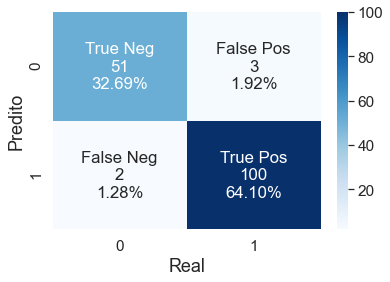

In [72]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');
plt.xlabel('Real',fontsize=18)
plt.ylabel('Predito',fontsize=18);

# Testando mais modelos e fazendo gridSeacrh dos hiperparâmetros

In [73]:
def get_models():
    '''
    Essa função seleciona diversos modelos de classificação para treino
    '''
    models = list()
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('DT',DecisionTreeClassifier(random_state=42,class_weight='balanced')))
    models.append(('RF',RandomForestClassifier(random_state=42,class_weight='balanced')))
    models.append(('Gaussian',GaussianNB()))

    return models

In [74]:
def evaluate_model(cv, model):
    '''
    Essa função faz o cross_validation dos modelos e imprime a acurácia correspondente
    '''
    X, y = get_dataset()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return mean(scores)

In [75]:
cv = KFold(n_splits=4, random_state=42, shuffle=True)

In [76]:
models = get_models()
ideal_results, cv_results = list(), list()

KNN: 0.923077 (0.021066)
DT: 0.950000 (0.011538)
RF: 0.963462 (0.009993)
Gaussian: 0.896154 (0.020712)


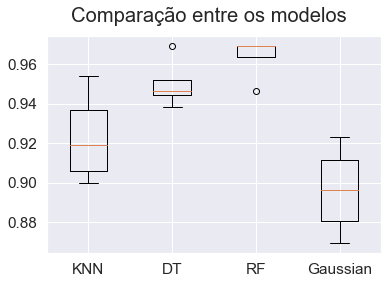

In [77]:
# avaliando os modelos em cada iteração
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv = KFold(n_splits=4, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    msg = "%s: %f (%f)" % (name, scores.mean(), scores.std())
    print(msg)
# boxplot dos modelos
fig = plt.figure()
fig.suptitle('Comparação entre os modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Dos modelos selecionados o **Random Forest** obteve maior acurácia e o menor desvio padrão.

In [78]:
params = {'n_estimators':[100,300], 'max_depth': [2, 3, 4,5], 'max_features':['auto', 'sqrt', 'log2']}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=5)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 300]},
             verbose=1)

In [79]:
rf_model = grid_search_cv.best_estimator_


In [80]:
y_pred = rf_model.predict(X_test)

In [81]:
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.93      0.89        54
    positive       0.96      0.92      0.94       102

    accuracy                           0.92       156
   macro avg       0.91      0.92      0.92       156
weighted avg       0.93      0.92      0.92       156



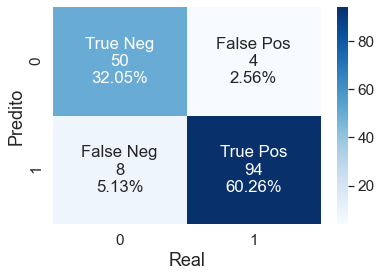

In [90]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');
plt.xlabel('Real',fontsize=18)
plt.ylabel('Predito',fontsize=18);
plt.savefig('../figures/classification_report.png',dpi=100,bbox_inches='tight')

In [93]:
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).to_frame()

feature_scores

,0
Polyuria,0.285935
Polydipsia,0.228894
Gender_Female,0.121463
sudden weight loss,0.099738
partial paresis,0.065068
Irritability,0.049407
Alopecia,0.043328
visual blurring,0.029450
Polyphagia,0.027086
Genital thrush,0.025224


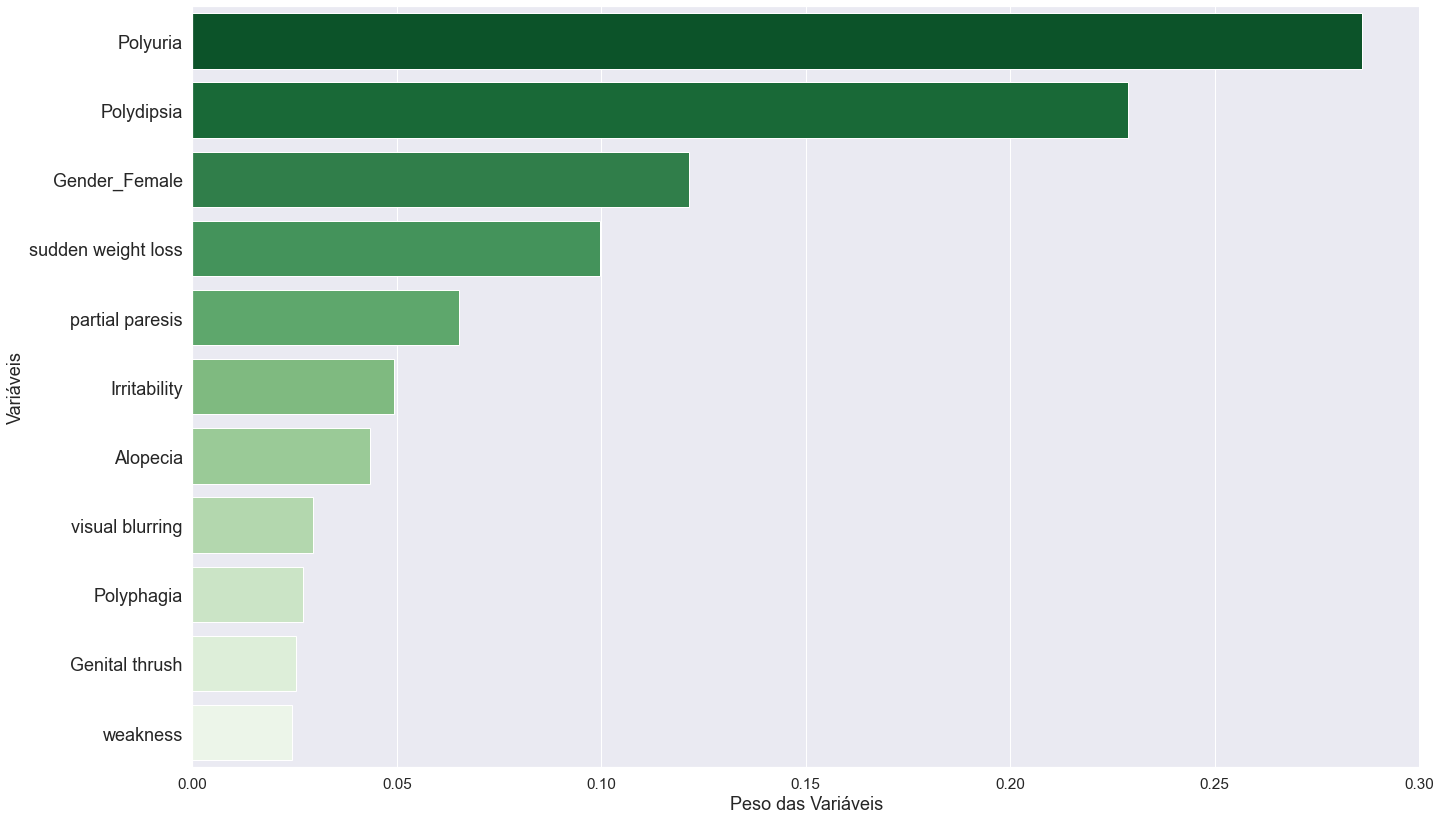

In [94]:
plt.figure(figsize=(22,14))

sns.set(font_scale=1.4)
sns.barplot(y=feature_scores.index,x=feature_scores[0],palette="Greens_r")
plt.yticks(fontsize=18)
plt.xticks()
plt.ylabel('Variáveis',fontsize=18)
plt.xlabel('Peso das Variáveis',fontsize=18);
plt.savefig('../figures/model_importance.png',dpi=100,bbox_inches='tight')

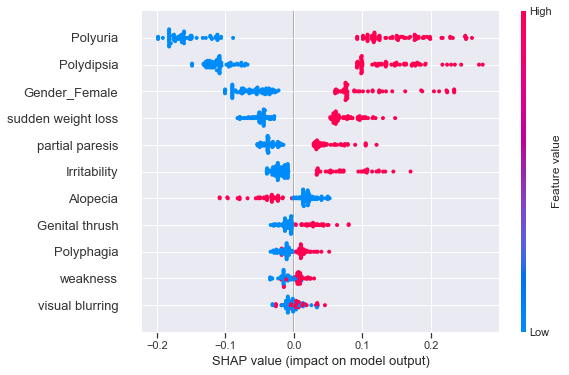

In [736]:

# Criando o objeto shap com base no modelo 
explainer = shap.TreeExplainer(rf_model)

# calculando o shap value
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)


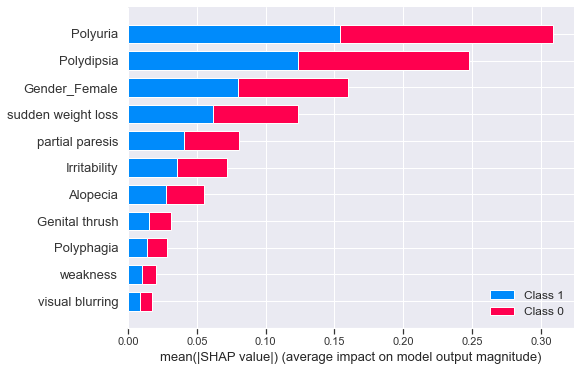

In [737]:
shap.summary_plot(shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


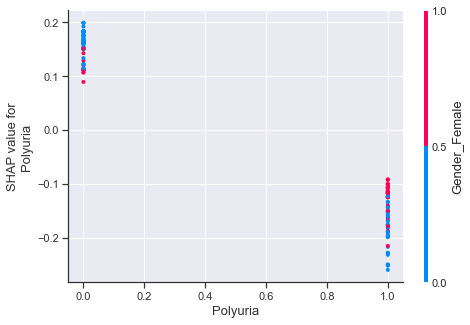

In [739]:
shap.dependence_plot("Polyuria", shap_values[0], X_test)


 O modelo poderá encontrar dificuldades de manter seu desempenho se a proporção de homens e mulheres for muito diferente dos dados utilizados. Além disso, se a distribuição dos dados de pessoas com Polydpsia for alterado significante, também, poderá impactar no seu desempenho já que essa variáveis são importantes no diagnóstico. Vale ressaltar, também, que o dataset é relativamente pequeno o que pode levar a diagnóstico incorretos conforme mais informações sejam fornecidas ao presente modelo.